### Day 2
#### 基于gallight分解类星体图像
* 作者: 朱帅儒（394，上海天文台）

* 更新于 2022-07-28

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

import galight.tools.astro_tools as astro_tools
from galight.data_process import DataProcess
from galight.tools.astro_tools import plt_fits, read_pixel_scale
from galight.fitting_specify import FittingSpecify
from galight.fitting_process import FittingProcess

warnings.filterwarnings("ignore")

### 导入数据

拍摄设备: HST WFC3 F140W
曝光时间: 2395.40s
pixel尺寸: 0.064200 arcsec/pixel


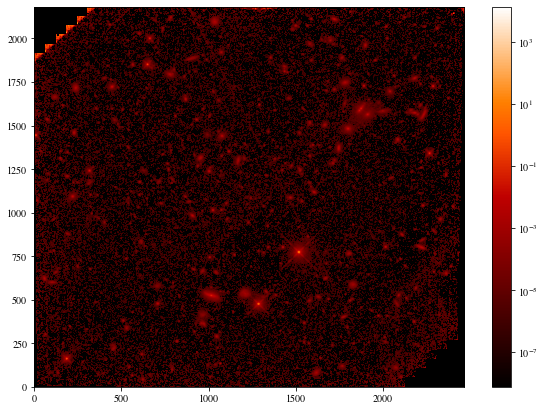

In [2]:
target_params = {}
target_params["ID"] = "CID216"
target_params["ra"] = 149.7918
target_params["dec"] = 1.8729

# 导入数据
hdul = fits.open("data/{:s}_final_drz.fits".format(target_params["ID"]))
# 头文件
pri_head = hdul[0].header
sci_head = hdul[1].header
# 图像数据
image = hdul[1].data
# 打印信息
print('拍摄设备:', pri_head['TELESCOP'], pri_head['PRIMESI'], pri_head['FILTER'])
print('曝光时间: {0:.2f}s'.format(pri_head['EXPTIME']) )
print('pixel尺寸: {0:3f}'.format(read_pixel_scale(sci_head)), 'arcsec/pixel')
# Check image
plt_fits(image, colorbar=True, figsize=(10,7))
# Generate the exp map
wht = hdul[2].data
exp =  astro_tools.read_fits_exp(pri_head)
exp_map = exp * wht /np.median(wht)

* 图像数据似乎是MAST内的三级数据产品，即用Astrodrizzle用默认参数进行叠加

* gallight的小工具使用起来很不错

### 准备拟合

在本次拟合中，需要准备的事项是
* 图像，图像的头文件，曝光分布，零点目标源的坐标。
这些材料主要通过DataProcess类来传递
* 需要准备目标源的一些信息：
例如: Cutout Size，源探测的参数等等，通过generate_target_materials方法准备
* 叠加PSF
利用find_PSF来寻找单个源的PSF，stack_PSF来ePSF

In [3]:
target_pos = target_params["ra"], target_params["dec"]
zp = (-2.5*np.log10(pri_head["PHOTFLAM"]) - 21.10 - 
        5*np.log10*(pri_head["PHOTPLAM"]) + 18.692)
data_process = DataProcess(fov_image=image, target_pos=target_pos, pos_type='wcs', header=sci_head,
                          rm_bkglight = True, exptime = exp_map, if_plot=False, zp = 26.450) 

data_process.generate_target_materials(radius=60, create_mask = False, 
                                        if_select_obj = False,
                                       nsigma=2.8, npixels = 15, 
                                       cut_kernel ='center_bright',if_plot=True)

TypeError: unsupported operand type(s) for *: 'int' and 'numpy.ufunc'

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

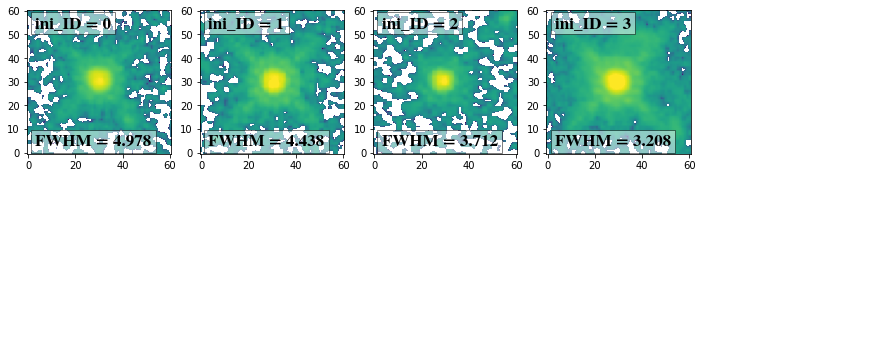

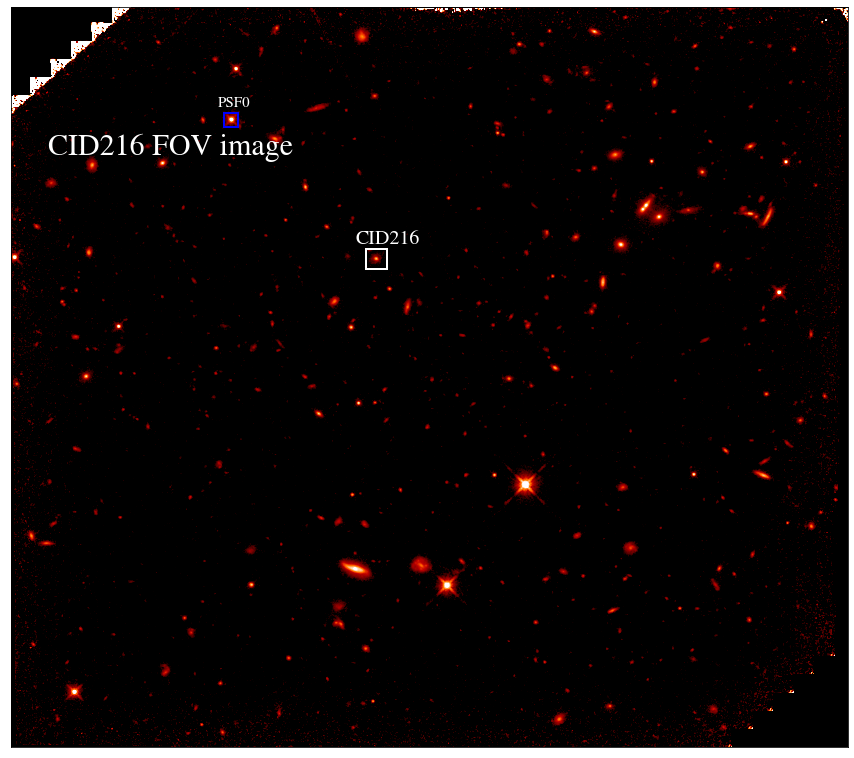

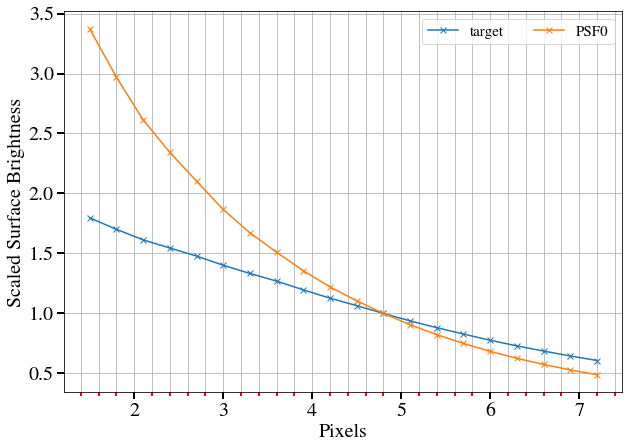

EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

EPSFBuilder converged after 7 iterations (of 10 maximum iterations)


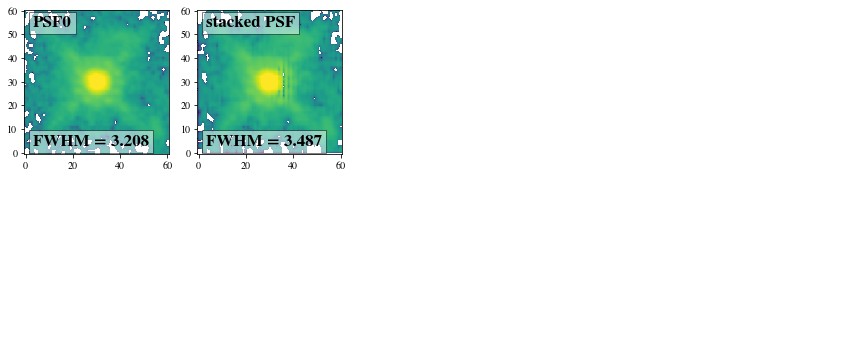

Plot residual:


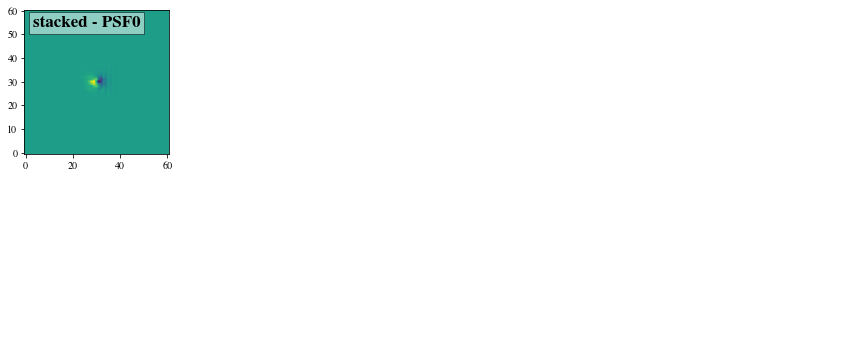

In [ ]:
data_process.find_PSF(radius = 30, if_filter=True, nearyby_obj_filter=True, user_option = True,
                     FWHM_sort= True, select_all=False)
data_process.plot_overview(label = target_params["ID"] +' FOV image', 
                    target_label = target_params["ID"])

data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]))

data_process.stack_PSF()

#### 检查拟合是否就绪？

In [ ]:
data_process.checkout()

The data_process is ready to go to pass to FittingSpecify!


#### 准备拟合参数

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


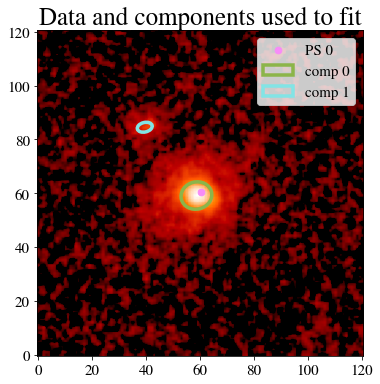

In [ ]:
fit_sepc = FittingSpecify(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 1)
fit_sepc.plot_fitting_sets()
fit_sepc.build_fitting_seq()

#### 执行拟合

In [ ]:
fit_run = FittingProcess(fit_sepc, savename = target_params["ID"]+'_fit_result', 
                            fitting_level='norm') 
fit_run.run(algorithm_list = ['PSO', 'PSO'])

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.0568064959514192 reduced X^2 of best position
-7727.369098396777 logL
14624.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.29759534648080804, 'n_sersic': 3.9628140859320795, 'e1': 0.13360441088463454, 'e2': 0.07976922721855809, 'center_x': 0.06277643646300164, 'center_y': -0.0653648633673094}, {'amp': 1, 'R_sersic': 0.24841771945927252, 'n_sersic': 0.759753492401199, 'e1': 0.2951920417214364, 'e2': -0.16798302897525005, 'center_x': 1.2862806397558464, 'center_y': 1.5674213630594487}] lens light result
[{'ra_image': array([0.0237032]), 'dec_image': array([0.04063805]), 'point_amp': array([1.])}] point source result
{} special param result
16.247148990631104 time used for  PSO
Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.055693479858421 reduced X^2 of best position
-7719.230724724774 logL
14624.0 effective number of data points
[] lens result
[

#### 展示拟合的结果

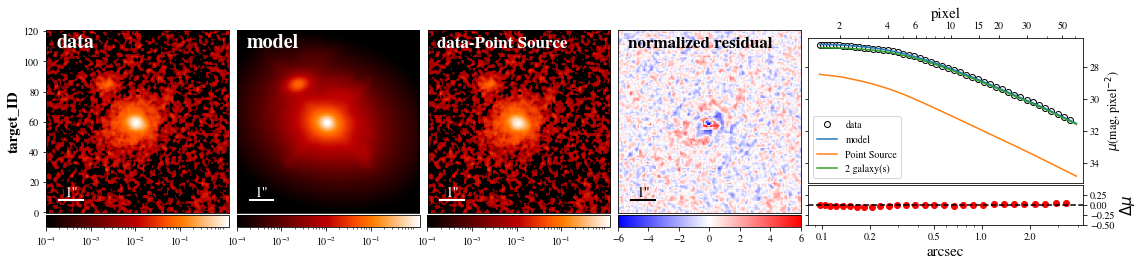

In [ ]:
fit_run.plot_final_qso_fit(target_ID='target_ID', save_plot=False )

In [ ]:
print("第'0'个galaxy的结果：\n",fit_run.final_result_galaxy[0])
print("第'0'个AGN的结果：\n",fit_run.final_result_ps[0])

第'0'个galaxy的结果：
 {'amp': 71.56665754334804, 'R_sersic': 0.29582674838828626, 'n_sersic': 3.850290391386502, 'e1': 0.13463439139753805, 'e2': 0.08295562297029098, 'center_x': 0.06268070236677888, 'center_y': -0.06487362849037139, 'phi_G': 0.27610670161278883, 'q': 0.7269079028513649, 'flux_sersic_model': 101.30449907711308, 'flux_within_frame': 98.31818741525026, 'magnitude': 21.468415341648875}
第'0'个AGN的结果：
 {'ra_image': array([0.02243252]), 'dec_image': array([0.04040474]), 'point_amp': array([5.16575492]), 'flux_within_frame': 5.162656129389763, 'magnitude': 24.667817002935887}
